<a href="https://colab.research.google.com/github/tairamashimo-t/cpu_train/blob/main/MotionRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gesture Recognition for ICM20948


## 1. Set up for only 1st time

In [ ]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

## 2. As first step, upload logged csv file per gesture

## 3. Set the configuration for model

In [ ]:
# Gesture List
GESTURES = ["wakeup", "up", "down", "left", "right", "forward", "back"]

# Sample per motion
SAMPLE_PER_MOTION = 80

# Training Data Ratio in Input Data 0~1 ※ 1-TRAINING_RATIO-TEST_RATIO=VALIDATION_RATIO
TRAINING_RATIO = 0.8

# Test Data Ratio in Input Data 0~1 ※ 1-TRAINING_RATIO-TEST_RATIO=VALIDATION_RATIO
TEST_RATIO = 0.1

# How Many Loop Training
EPOCH = 1000

## 4. Check Data as Graph (Option)


<ipython-input-12-ffb0fcba18dc>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-12-ffb0fcba18dc>:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-12-ffb0fcba18dc>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


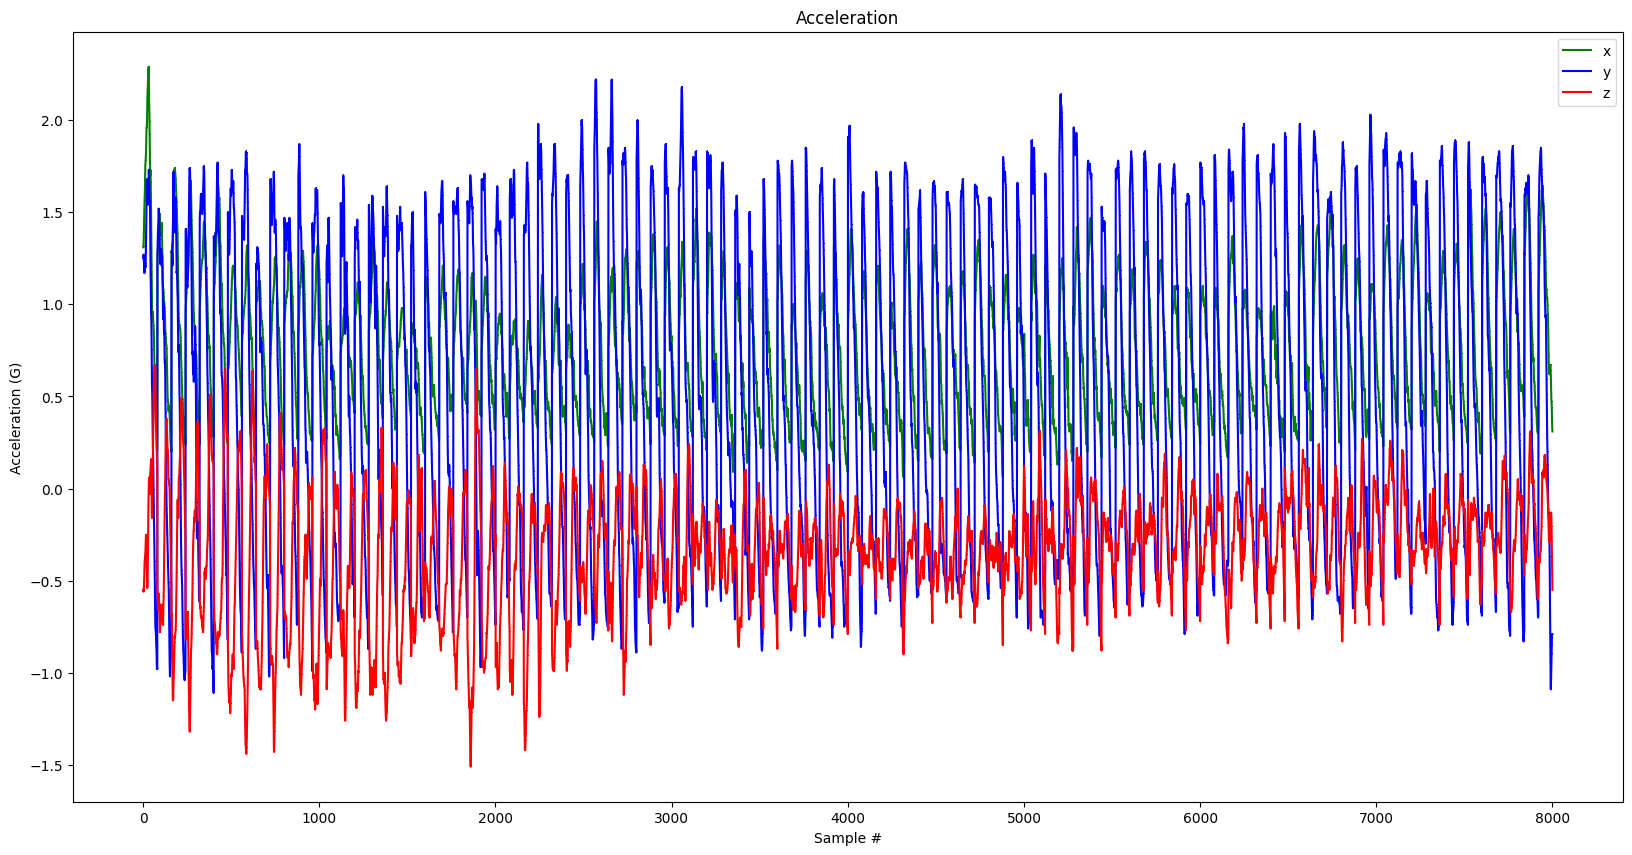

<ipython-input-12-ffb0fcba18dc>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-12-ffb0fcba18dc>:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-12-ffb0fcba18dc>:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


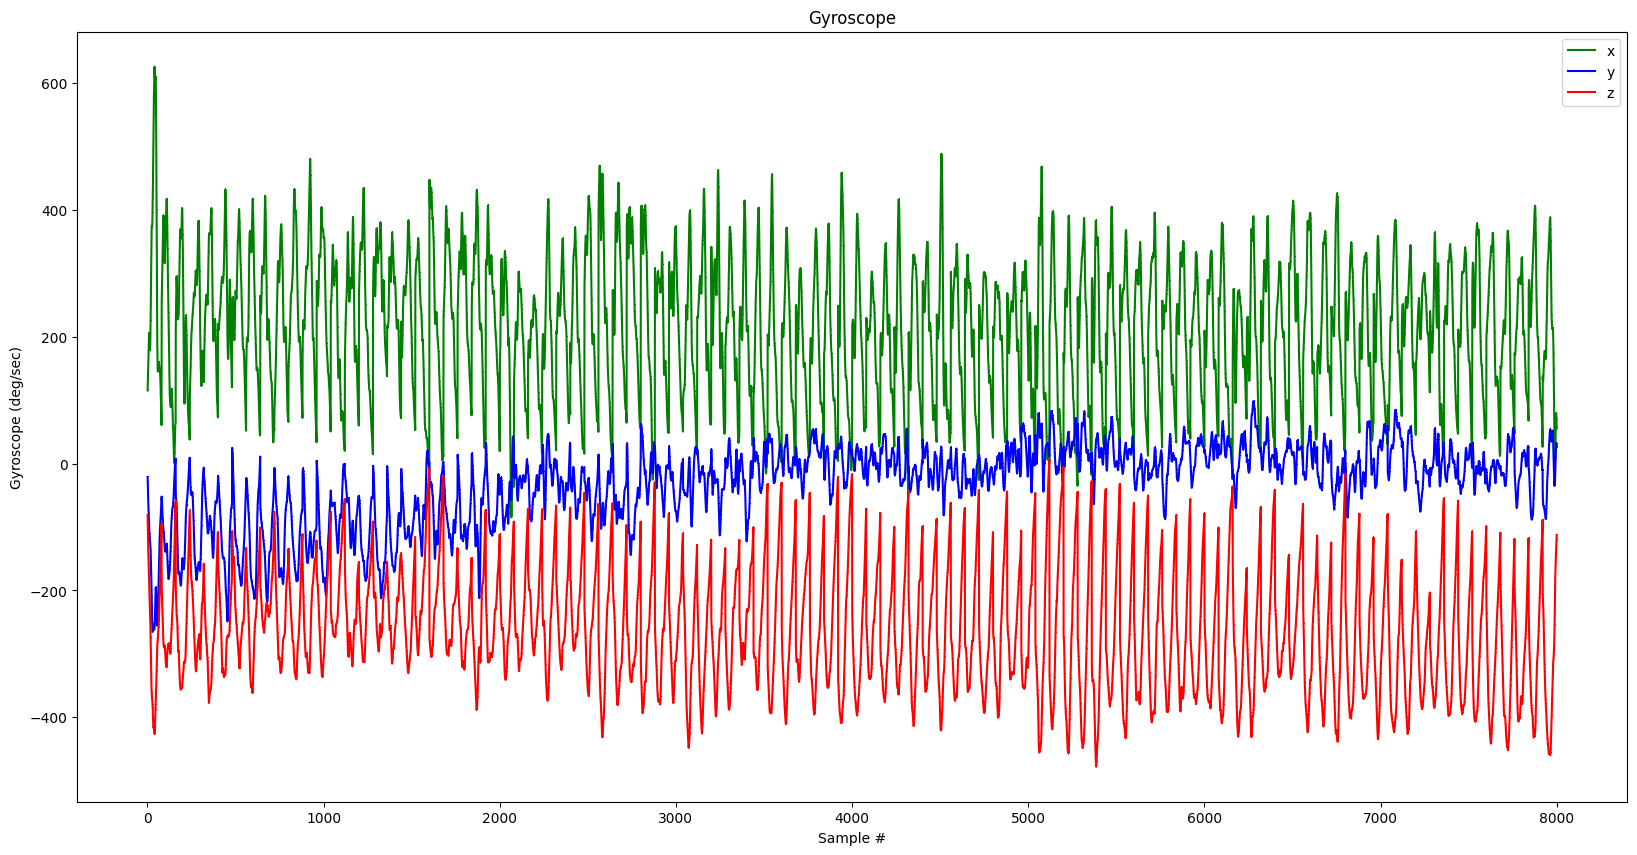

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Modify the index that indicate motion that you want to check
gesture_name = GESTURES[0]

filename = gesture_name + ".csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# Auto All Step

## 5. Prepare the Data as Tensor

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

NUM_GESTURES = len(GESTURES)

ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  num_recordings = int(df.shape[0] / SAMPLE_PER_MOTION)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLE_PER_MOTION):
      index = i * SAMPLE_PER_MOTION + j
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.12.0

Processing index 0 for gesture 'wakeup'.
	There are 100 recordings of the wakeup gesture.
Processing index 1 for gesture 'up'.
	There are 100 recordings of the up gesture.
Processing index 2 for gesture 'down'.
	There are 100 recordings of the down gesture.
Processing index 3 for gesture 'left'.
	There are 100 recordings of the left gesture.
Processing index 4 for gesture 'right'.
	There are 100 recordings of the right gesture.
Processing index 5 for gesture 'forward'.
	There are 100 recordings of the forward gesture.
Processing index 6 for gesture 'back'.
	There are 100 recordings of the back gesture.
Data set parsing and preparation complete.


## 6. Randomize and Split the Input and Output Pairs for Training

In [ ]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(TRAINING_RATIO * num_inputs)
TEST_SPLIT = int(TEST_RATIO * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## 7. Build and Train the Model

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=EPOCH, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/1000
560/560 [==============================] - 7s 3ms/step - loss: 0.1225 - accuracy: 0.1625 - val_loss: 0.1211 - val_accuracy: 0.1143
Epoch 2/1000
560/560 [==============================] - 2s 3ms/step - loss: 0.1188 - accuracy: 0.2000 - val_loss: 0.1171 - val_accuracy: 0.1143
Epoch 3/1000
560/560 [==============================] - 2s 3ms/step - loss: 0.1106 - accuracy: 0.2304 - val_loss: 0.1151 - val_accuracy: 0.1286
Epoch 4/1000
560/560 [==============================] - 2s 3ms/step - loss: 0.1040 - accuracy: 0.2839 - val_loss: 0.1072 - val_accuracy: 0.2429
Epoch 5/1000
560/560 [==============================] - 2s 3ms/step - loss: 0.1014 - accuracy: 0.3393 - val_loss: 0.1048 - val_accuracy: 0.2857
Epoch 6/1000
560/560 [==============================] - 2s 3ms/step - loss: 0.0993 - accuracy: 0.3536 - val_loss: 0.0997 - val_accuracy: 0.4571
Epoch 7/1000
560/560 [==============================] - 2s 4ms/step - loss: 0.0968 - accuracy: 0.3911 - val_loss: 0.0999 - val_accuracy:

## 8. Check the Accuracy

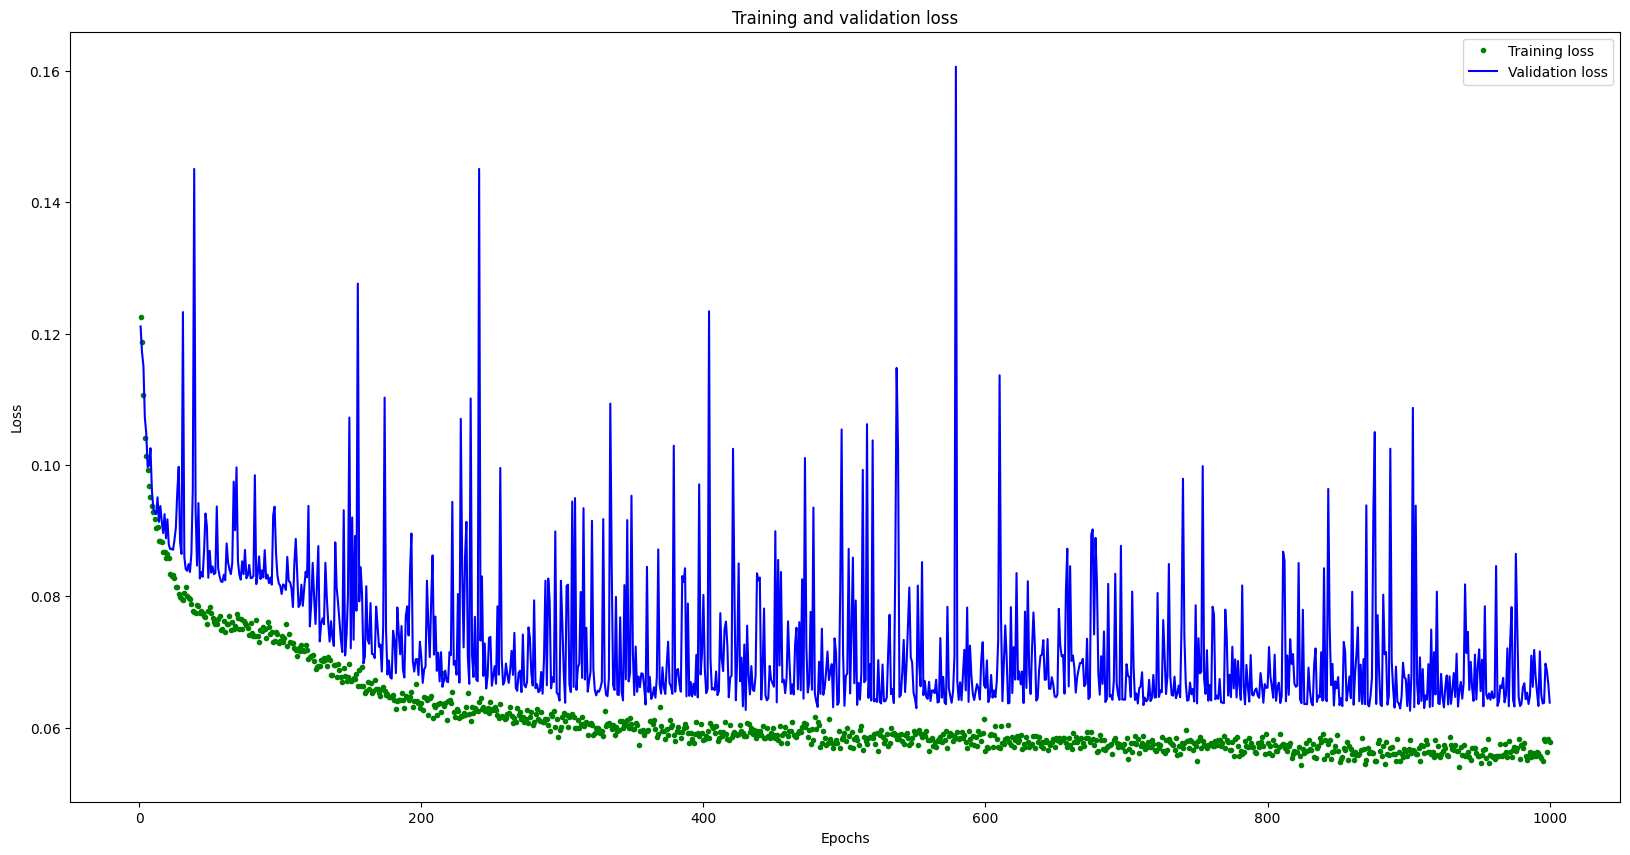

[20.0, 10.0]


In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

## 9. Check the Accuracy Finely

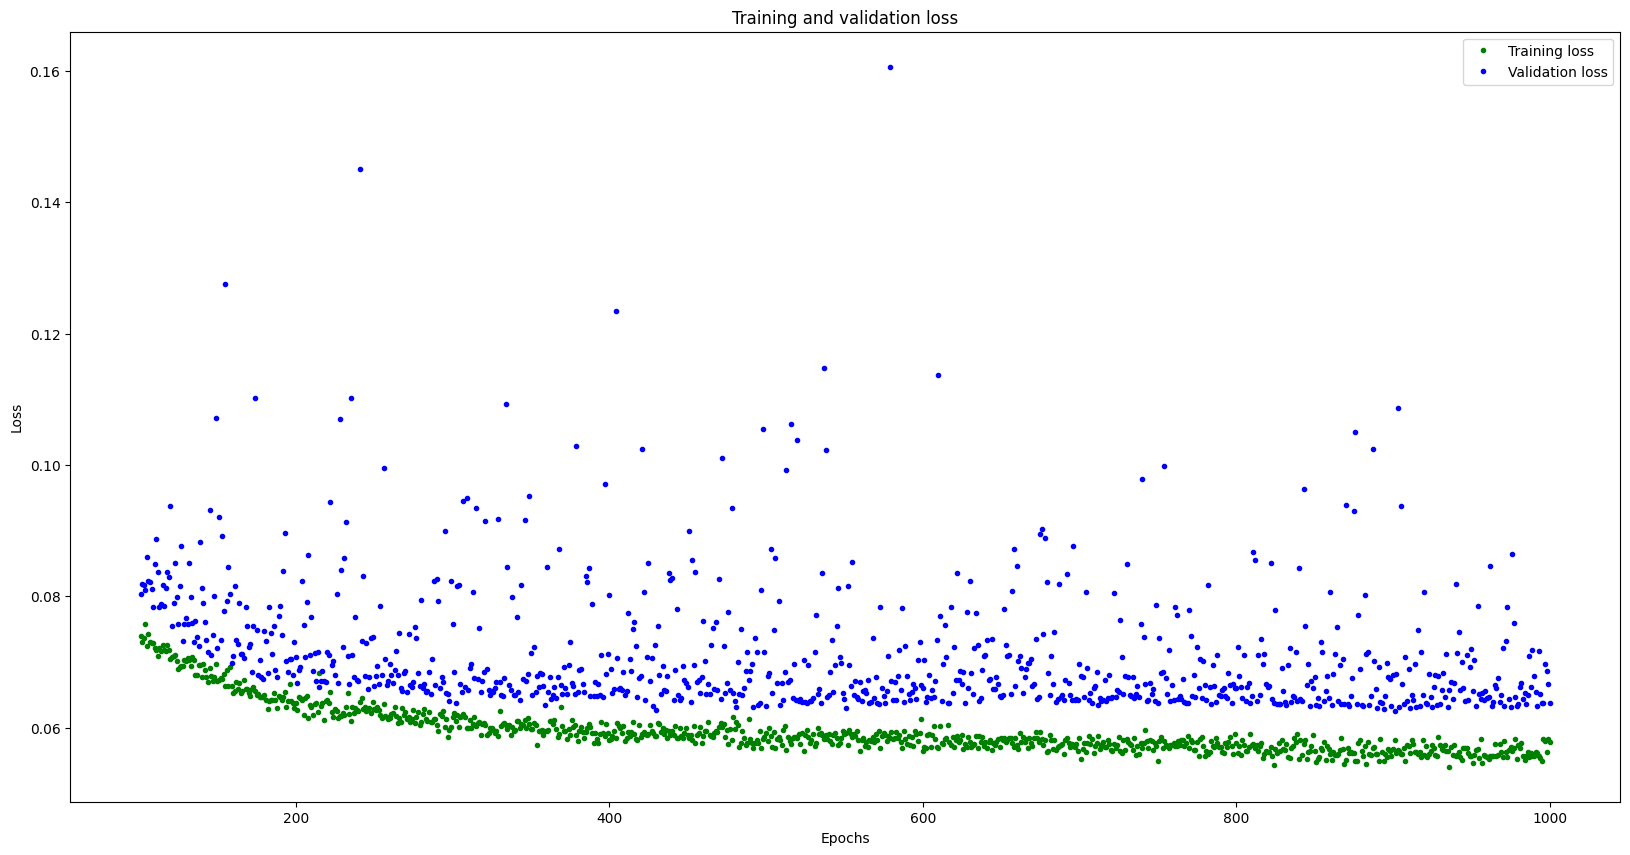

In [ ]:
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 10. Check the Accuracy

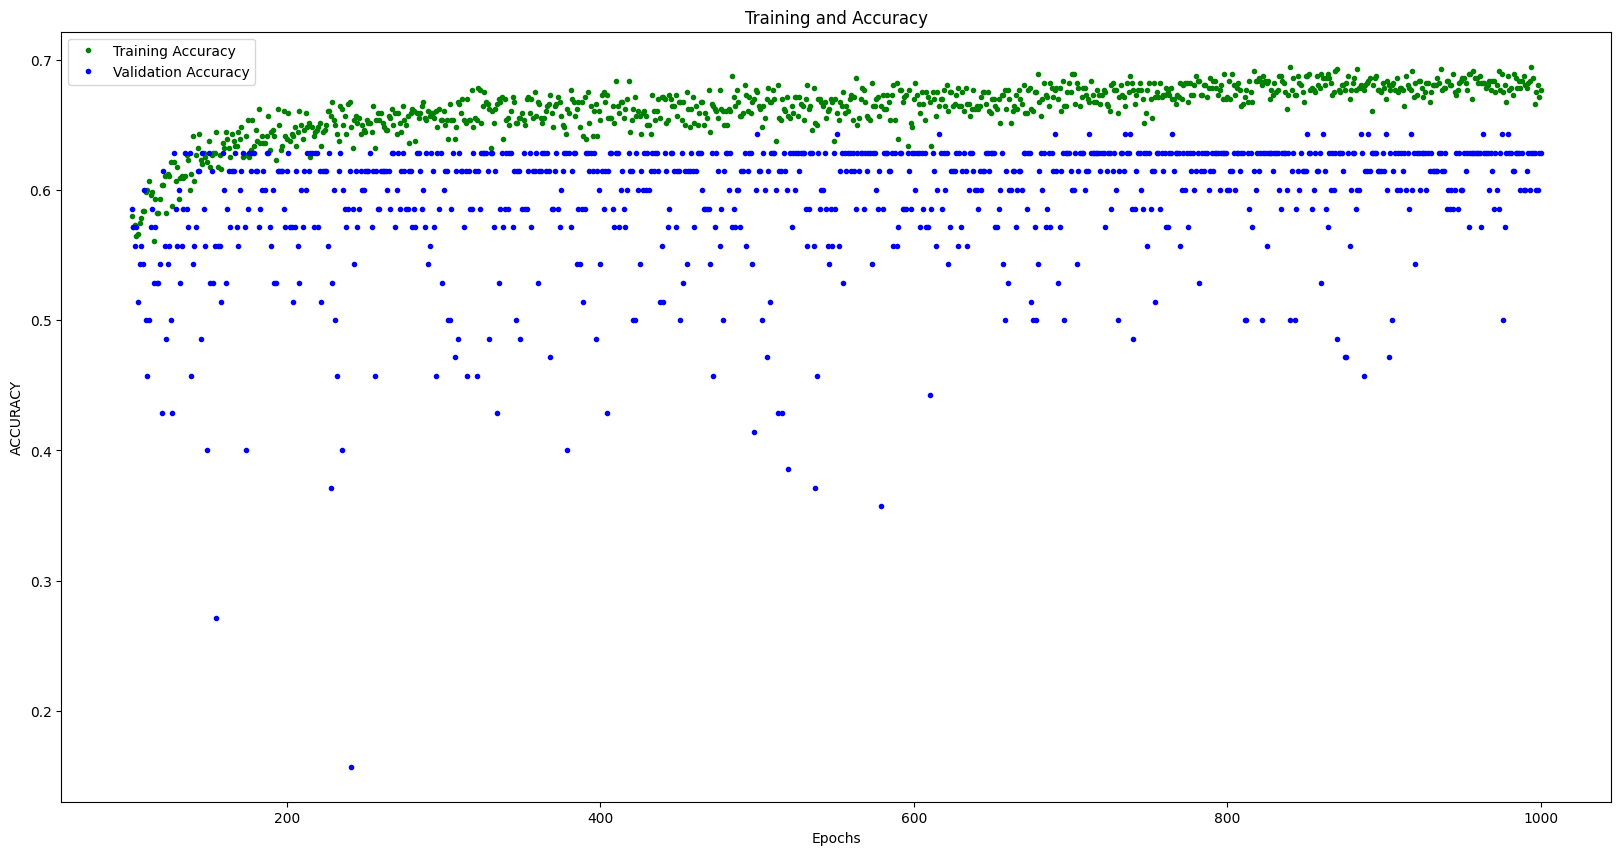

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs[SKIP:], accuracy[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs[SKIP:], val_accuracy[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

## 11. Convert the Trained model to Header File

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Model is 101800 bytes
Header file, model.h, is 627,802 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
